In [44]:
## This is just a practice problem for predicting loan application approvals with a relatively small dataset
## We'll use pandas for data manupulations and wrangling and sklearn for fitting machine learning models.

In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegressionCV, SGDClassifier, LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

In [46]:
df= pd.read_csv('../input/train_u6lujuX_CVtuZ9i (1).csv')

In [47]:
df.head()
# checking the dataset

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [48]:
df.drop('Loan_ID', axis=1, inplace= True)
#we'll drop the ID variables as it does not add to the model

In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 12 columns):
Gender               601 non-null object
Married              611 non-null object
Dependents           599 non-null object
Education            614 non-null object
Self_Employed        582 non-null object
ApplicantIncome      614 non-null int64
CoapplicantIncome    614 non-null float64
LoanAmount           592 non-null float64
Loan_Amount_Term     600 non-null float64
Credit_History       564 non-null float64
Property_Area        614 non-null object
Loan_Status          614 non-null object
dtypes: float64(4), int64(1), object(7)
memory usage: 57.6+ KB


In [50]:
obj_cols= [*df.select_dtypes('object').columns]
obj_cols.remove('Loan_Status')
# as Loan_Status is a target variable

In [51]:
obj_cols

['Gender',
 'Married',
 'Dependents',
 'Education',
 'Self_Employed',
 'Property_Area']

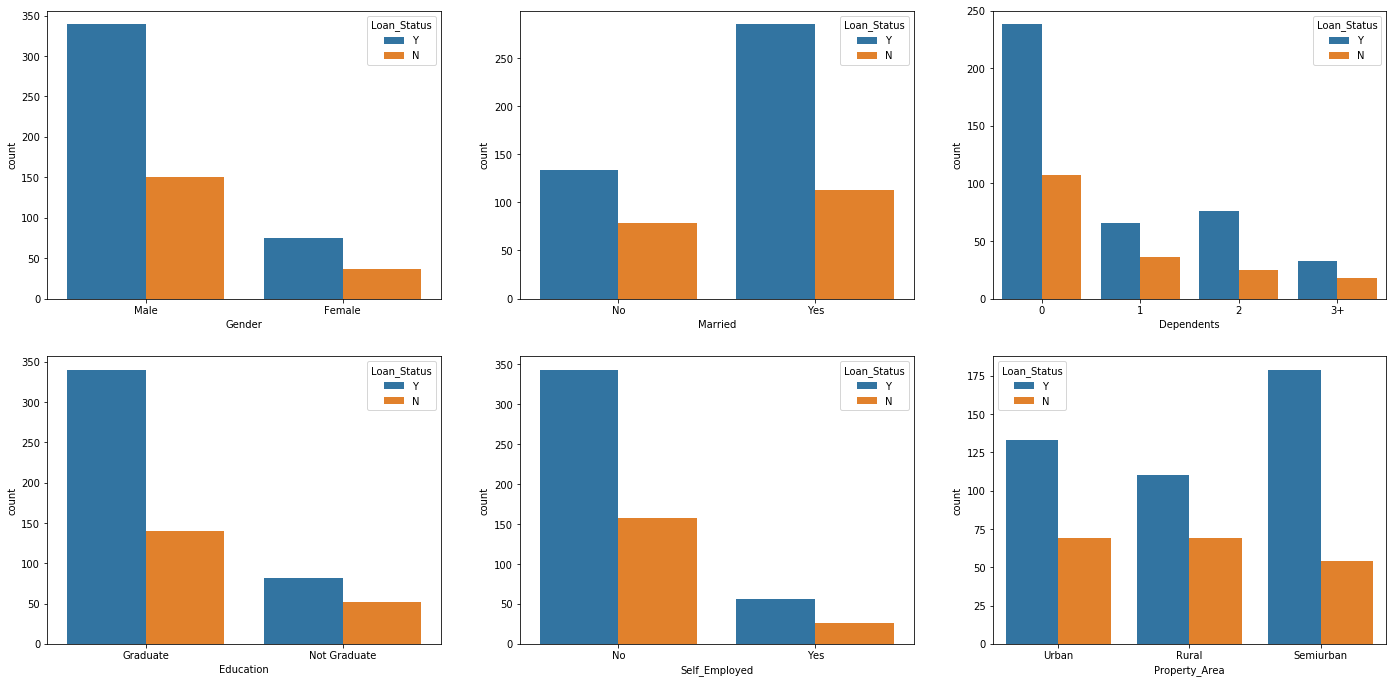

In [52]:
plt.figure(figsize=(24, 18))

for idx, cols in enumerate(obj_cols):
    
    plt.subplot(3, 3, idx+1)
    
    sns.countplot(cols, data= df, hue='Loan_Status')

In [53]:
num_cols= [*df.select_dtypes(['Int64', 'Float64']).columns]
num_cols.remove('Loan_Amount_Term')
num_cols.remove('Credit_History')
num_cols

['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount']

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


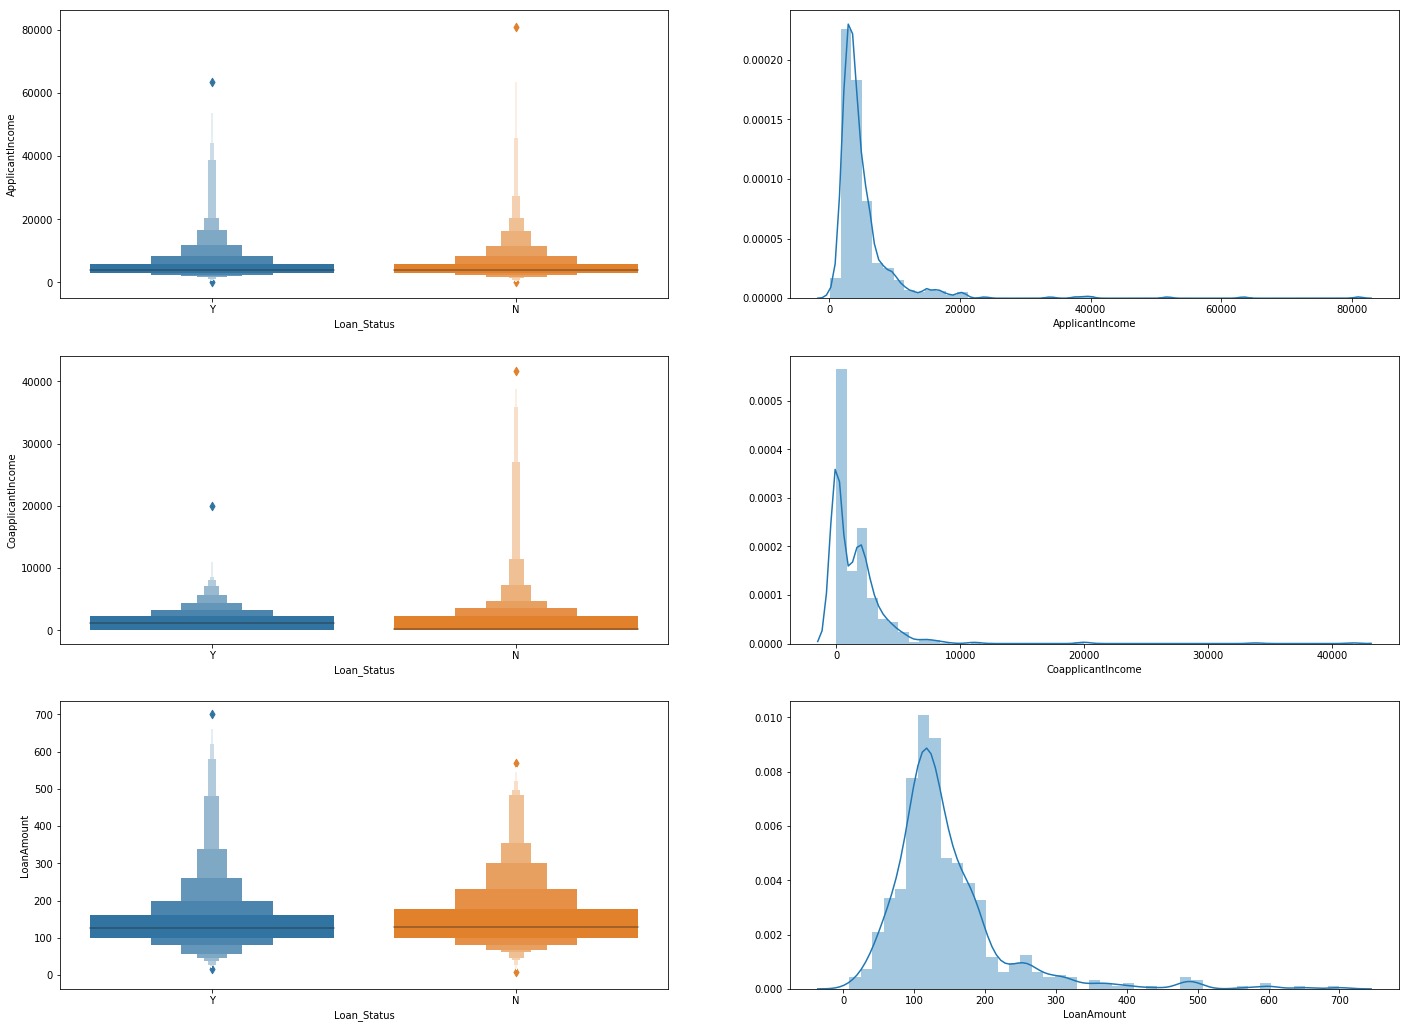

In [54]:
plt.figure(figsize=(24, 18))
count = 1

for cols in num_cols:
    
    plt.subplot(3, 2, count)
    
    sns.boxenplot(x='Loan_Status', y= cols, data= df)
    
    count +=1
    
    plt.subplot(3, 2, count)
    
    sns.distplot(df.loc[df[cols].notna(), cols])
    
    count+=1

In [55]:
df.describe()
# we see that LoanAmount, Loan_Amount_Term and Credit History have a some missing values.
"""we also see that there could be possible outliers in the dataset for ApplicantIncome, CoapplicantIncome 
and Loan_Amount."""
# We see that there are places where there is 0 for Coapplicant income, this might help us create a new feature
# Credit history seems to be a binary filed with just 0s and 1s, we will consider this a categorical feature.

'we also see that there could be possible outliers in the dataset for ApplicantIncome, CoapplicantIncome \nand Loan_Amount.'

In [56]:
df.isna().sum()
"""we see that there are missing values in more than the columns list above, this can also be found from 
df.info() method"""
"""# we'll use a simple imputer for missing values and create a new column for Loan_Amount_Term 
where 1 idicates term 360 months and 0 for rest"""

"# we'll use a simple imputer for missing values and create a new column for Loan_Amount_Term \nwhere 1 idicates term 360 months and 0 for rest"

In [57]:
df.Loan_Status.replace({'Y': 0, 'N': 1}, inplace= True)

In [58]:
df['Loan_Status']= df.Loan_Status.astype(int)

In [77]:
dummies= pd.get_dummies(df, drop_first=True)

In [78]:
# we will now impute values

SimImp = SimpleImputer()

train= pd.DataFrame(SimImp.fit_transform(dummies), columns=dummies.columns)

In [61]:
train.sample(10)

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Loan_Status,Gender_Male,Married_Yes,Dependents_1,Dependents_2,Dependents_3+,Education_Not Graduate,Self_Employed_Yes,Property_Area_Semiurban,Property_Area_Urban
291,4400.0,0.0,127.0,360.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
27,4226.0,1040.0,110.0,360.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
101,4843.0,3806.0,151.0,360.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
481,3095.0,0.0,113.0,360.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
519,3400.0,0.0,95.0,360.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
75,3750.0,0.0,113.0,480.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
10,3200.0,700.0,70.0,360.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
201,4923.0,0.0,166.0,360.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
440,3660.0,5064.0,187.0,360.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
581,1836.0,33837.0,90.0,360.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [62]:
train.info()
# we see that all missing values have been replaced

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 15 columns):
ApplicantIncome            614 non-null float64
CoapplicantIncome          614 non-null float64
LoanAmount                 614 non-null float64
Loan_Amount_Term           614 non-null float64
Credit_History             614 non-null float64
Loan_Status                614 non-null float64
Gender_Male                614 non-null float64
Married_Yes                614 non-null float64
Dependents_1               614 non-null float64
Dependents_2               614 non-null float64
Dependents_3+              614 non-null float64
Education_Not Graduate     614 non-null float64
Self_Employed_Yes          614 non-null float64
Property_Area_Semiurban    614 non-null float64
Property_Area_Urban        614 non-null float64
dtypes: float64(15)
memory usage: 72.0 KB


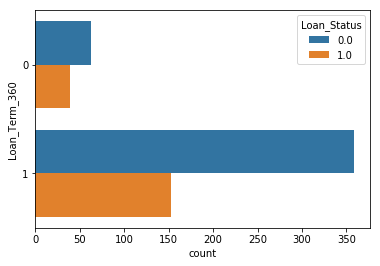

In [79]:
train['Loan_Term_360']= np.where(train.Loan_Amount_Term == 360, 1, 0)
# we'll create a binary column here for loan amount term and check the data with a count plot
sns.countplot(y='Loan_Term_360', data= train, hue='Loan_Status')
# looks like there is some importance and can be used in the model

In [80]:
train.drop('Loan_Amount_Term', inplace= True, axis= 1)

In [65]:
train.head()
# we'll also create a new variable to called "NoCoapplicantIncome" to check it's significane in the model.

,ApplicantIncome,CoapplicantIncome,LoanAmount,Credit_History,Loan_Status,Gender_Male,Married_Yes,Dependents_1,Dependents_2,Dependents_3+,Education_Not Graduate,Self_Employed_Yes,Property_Area_Semiurban,Property_Area_Urban,Loan_Term_360
0,5849.0,0.0,146.412162,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1
1,4583.0,1508.0,128.000000,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,3000.0,0.0,66.000000,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1
3,2583.0,2358.0,120.000000,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1
4,6000.0,0.0,141.000000,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1


In [81]:
NoCoapplicantIncome= np.where(train['CoapplicantIncome']== 0, 1, 0)

'we see that regardless of coapplicant income loans have been rejected in equal amounts,\nthis variable might not help'

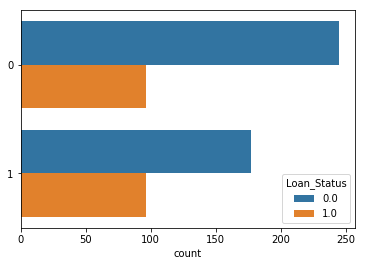

In [82]:
sns.countplot(y=NoCoapplicantIncome, hue=train.Loan_Status)
"""we see that regardless of coapplicant income loans have been rejected in equal amounts,
this variable might not help"""

In [83]:
#we'll split the data to train and test set

obj_train = train.drop(num_cols, axis=1)

# for this model we'll only use the categorical features for training 

X, y = obj_train.drop('Loan_Status', axis=1), obj_train.Loan_Status

X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.2, random_state=123, stratify= y)

In [86]:
logit= LogisticRegressionCV()
logit.fit(X_train, y_train)

logit_pred= logit.predict(X_test)

print(accuracy_score(y_test, logit_pred))

confusion_matrix(y_test, logit_pred)

0.7804878048780488


/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


array([[82,  3],
       [24, 14]])

In [87]:
sgd_clf = SGDClassifier()

sgd_clf.fit(X_train, y_train)

sgd_pred= sgd_clf.predict(X_test)

print(accuracy_score(y_test, sgd_pred))

confusion_matrix(y_test, sgd_pred)


0.7398373983739838


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


array([[83,  2],
       [30,  8]])

### We see that we get a better prediction using Logit model. We will stop here. as we have close to 80% accuracy in the model.